<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/histone_lstm_layer_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 8.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# module auto reload
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [ ]:
# copy modules
!cp -r '/content/drive/My Drive/dna_NN_theory/reading_dna_scripts' .
!ls reading_dna_scripts

download.py  load.py


In [ ]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

from reading_dna_scripts.load import read_fasta

In [ ]:
DIR = '/content/drive/My Drive/'
DATA_DIR = DIR + 'data/histone/'
MODEL_DIR = DIR + 'dna_NN_theory/models/'

In [ ]:
file = DIR + 'H3.fasta'
sequences, labels = read_fasta(file)

14963 samples loaded


In [ ]:
# split
SEED = 3264
test_size = 0.15
val_size = 0.15

split_options = dict(test_size=test_size, stratify=labels, random_state=SEED)
x_train_val, xtest, y_train_val, ytest = train_test_split(sequences, labels, **split_options)
# normalize val_size and update options
split_options.update(dict(test_size=val_size/(1-test_size), stratify=y_train_val))
xtrain, xval, ytrain, yval = train_test_split(x_train_val, y_train_val, **split_options)
del x_train_val, y_train_val
print('train size:', len(xtrain))
print('test size: ', len(xval))
print('val size:  ', len(xtest))

train size: 10473
test size:  2245
val size:   2245


In [ ]:
x_train[0]

'CGAACCTGCAGATGATGCAGCAATGGAATTTGGACGTCCAGAAGCTGAAATTGAAACTCCAGAAGTAAATGAGTCTATAGAAGATGCCAATGAACCTGCGGAGGATTCCAATGAACCTGTGGAGGATTCCAACAAACCTGTGAAGGATTCCAACAAACCTGTGGAGGATTCCAACAAACCTGTGGAGGATTCCAACAAACCTGTGGAGGATTCCAACAAACCTGTGGAGGATGCCAATGAACCTGTGGAAGATACCAGTGAACCTGTGGAGGATGCCGGTGAACCCGTACAAGAAACCAACGAGTTTACTACCGACATTGCCTCTCCAAGACATCAAGAAGAAGATATAGAACTTGAAGCCGAACCTAAAGATGCTACCGAAAGTGTTGCAGTCGAGCCATCCAATGAAGATGTAAAACCAGAAGAAAAAGGTTCAGAGGCAGAAGACGATATCAACAACGTTTCCAAGGAGGCTGCCTCTGGTGAGAGTACTACCCACC'

In [ ]:
ytrain[:10]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 0]

In [ ]:
seq_len = len(xtrain[0])
print("The length of the sequence is", seq_len)

The length of the sequence is 500


In [ ]:
word_size = 1
neucleotides = 'ACGT'
vocab = [''.join(p) for p in product(neucleotides, repeat=word_size)]
# word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(neucleotides)
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [ ]:
def ds_preprocess(x, y):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, y

In [ ]:
BATCH_SIZE = 256
xtrain_ds = Dataset.from_tensor_slices((xtrain, ytrain)).map(ds_preprocess).batch(BATCH_SIZE)
xval_ds = Dataset.from_tensor_slices((xval, yval)).map(ds_preprocess).batch(BATCH_SIZE)
xtest_ds = Dataset.from_tensor_slices((xtest, ytest)).map(ds_preprocess).batch(BATCH_SIZE)

In [ ]:
latent_size = 256

model = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),    
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),  
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(16, activation="relu"), 
    keras.layers.Dropout(0.2),   
    keras.layers.Dense(1, activation="sigmoid")                               
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 256)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.BinaryCrossentropy(), metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)
hist = model.fit(xtrain_ds, validation_data=xval_ds, epochs=3000, callbacks=[es_cb])

Epoch 1/3000
41/41 [==============================] - 11s 223ms/step - loss: 0.6919 - accuracy: 0.5224 - val_loss: 0.6726 - val_accuracy: 0.6579
Epoch 2/3000
41/41 [==============================] - 9s 216ms/step - loss: 0.6883 - accuracy: 0.5522 - val_loss: 0.6714 - val_accuracy: 0.6557
Epoch 3/3000
41/41 [==============================] - 9s 217ms/step - loss: 0.6859 - accuracy: 0.5632 - val_loss: 0.6842 - val_accuracy: 0.5639
Epoch 4/3000
41/41 [==============================] - 9s 214ms/step - loss: 0.6783 - accuracy: 0.5905 - val_loss: 0.6920 - val_accuracy: 0.5131
Epoch 5/3000
41/41 [==============================] - 9s 212ms/step - loss: 0.6921 - accuracy: 0.5234 - val_loss: 0.6623 - val_accuracy: 0.6633
Epoch 6/3000
41/41 [==============================] - 9s 211ms/step - loss: 0.6737 - accuracy: 0.6089 - val_loss: 0.6922 - val_accuracy: 0.5020
Epoch 7/3000
41/41 [==============================] - 9s 211ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6904 - val_accuracy

In [ ]:
# saving current model
date = '_20210310'
suffix = "baseline_histone_adam256"
model.save(MODEL_DIR+suffix+date+".h5")

In [ ]:
def save_hist():
  filename = DIR + 'dna_NN_theory/histone/' + suffix + "_history.csv"
  hist_df = pd.DataFrame(hist.history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)
save_hist()

In [ ]:
ytrain_pred = model.predict(xtrain_ds)
yval_pred = model.predict(xval_ds)
ytest_pred = model.predict(xtest_ds)

In [ ]:
def save_prediction():
  res = [ytrain, ytrain_pred, yval, yval_pred, ytest, ytest_pred]
  i = 0
  for ds in ['train', 'val', 'test']:
    filename = DIR + 'dna_NN_theory/histone/' + suffix + "_" + ds + "_prediction.csv"
    df = pd.DataFrame()
    df[ds] = res[i]
    i += 1
    df[ds+'_pred'] = res[i]
    i += 1
    with open(filename, mode='w') as f:
      df.to_csv(f)
  
save_prediction()

In [ ]:
### ref: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
def plot_ROC(label, pred, title="ROC"):
  fpr, tpr, threshold = metrics.roc_curve(label, pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title(title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

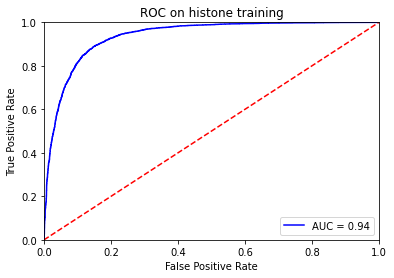

In [ ]:
plot_ROC(ytrain,ytrain_pred, title='ROC on histone training')

In [ ]:
### ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
def plot_recall_precision(label, pred, title="RP"):
  precision, recall, thresholds = metrics.precision_recall_curve(label, pred)
  no_skill = np.sum(label) / len(label)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random')
  plt.plot(recall, precision, marker='.', label='model')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

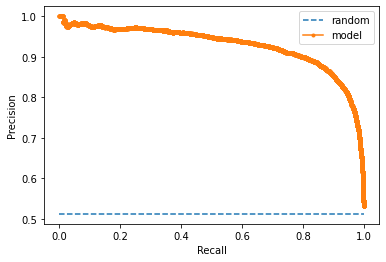

In [ ]:
plot_recall_precision(ytrain, ytrain_pred, title='precision/recall on histone training')

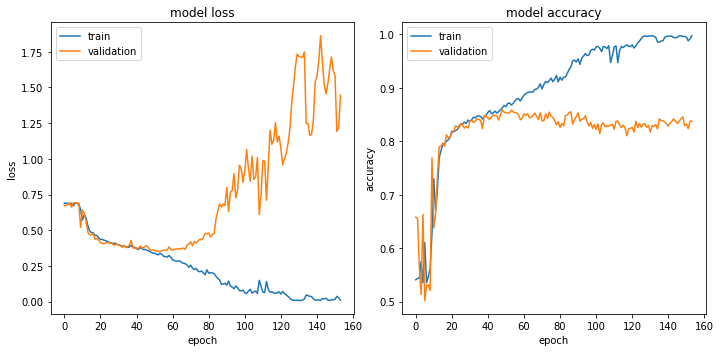

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(hist.history['loss'], label='training')
  ax1.plot(hist.history['val_loss'], label='validation')
  ax1.set_title('model loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist.history['accuracy'], label='training')
  ax2.plot(hist.history['val_accuracy'], label='validation')
  ax2.set_title('model accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
def eval_model(model, ds, ds_name="Training"):
  loss, acc = model.evaluate(ds, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

eval_model(model, xtrain_ds, "Training")
eval_model(model, xval_ds, "Validation")
eval_model(model, xtest_ds, "Test")

Training Dataset: loss = 0.322 and acccuracy = 86.9%
Validation Dataset: loss = 0.351 and acccuracy = 85.79%
Test Dataset: loss = 0.361 and acccuracy = 85.39%
